# Stauff-Klevens Demonstration

The Stauff-Klevens relationship is a well-known equation describing how the CMC decreases exponentially as chain length increases:

$$
    \ln X_{cmc} = A - Bn_C
$$

where $n_C$ is the number of carbon atoms in the chain and $A$ and $B$ are adjustable parameters, which are different depending on the homologous series.
That is, we need to fit a different $A$ and $B$ for each head group.

Here we demonstrate a quick way of implementing this relationship for a dataset of surfactants.

In [1]:
from typing import Dict, List
from itertools import takewhile

import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.linear_model import LinearRegression
from camcann.data import io

%matplotlib inline

First, we load the data and explore it.

In [2]:
dataset_name = io.QinDatasets.QIN_ALL_RESULTS
dataset = io.DataReader(dataset_name)
df = dataset.df

df.head()

,no,smiles,exp,traintest,pred,type,err
0,0,CCCCCCCCC(O)CO,3.361728,train,3.284244,nonionic,0.006004
1,1,CCCCCCCCC(O)CCO,3.361728,train,3.240318,nonionic,0.014740
2,2,CCCCCCCCCCCCC(O)CCO,1.113943,train,1.194439,nonionic,0.006479
3,3,CCCCCCCCOCCO,3.690196,train,3.669114,nonionic,0.000444
4,4,CCCCCCCCOCCOCCOCCO,3.875061,train,3.857243,nonionic,0.000318


In [3]:
def find_series(smiles: List[str]):
    """Find homologous series from a list of SMILES strings."""
    NUM_SMILES = len(smiles)

    num_series: int = 0
    num_with_series: int = 0
    num_without_series: int = 0

    series_matrix = np.zeros((NUM_SMILES, NUM_SMILES))
    chain_lengths: Dict[int, int] = dict()
    series_labels: Dict[int, int] = dict()

    for i, current_smiles in enumerate(smiles):
        has_series = (series_matrix[i, :] > 0).any()
        if has_series:
            # Has already been assigned a series from previous iteration
            continue

        for delta, comp_smiles in enumerate(smiles[i + 1 :]):
            # Compare string representation from right to left.
            # If all that remains after we've finished overlapping are 'C's, we've got a match.
            j = i + delta + 1
            if (series_matrix[j, :]).any():
                # Has already been assigned a series from previous iteration
                continue

            current_mol_smaller = len(current_smiles) < len(comp_smiles)
            mols = sorted([current_smiles, comp_smiles], key=len)
            smaller_mol, larger_mol = mols

            smaller_len = len(smaller_mol)

            smaller_mol_substring = smaller_mol[::-1]
            larger_mol_substring = larger_mol[: -(smaller_len + 1) : -1]

            match = smaller_mol_substring == larger_mol_substring
            if match:
                num_with_series += 1
                if not has_series:
                    num_series += 1
                    num_with_series += 1

                has_series = True

                # Count size of chain
                smaller_chain = len(list(takewhile(lambda x: x == "C", smaller_mol)))
                larger_chain = len(list(takewhile(lambda x: x == "C", larger_mol)))

                headgroup = smaller_mol[smaller_chain:]

                smaller_idx = i if current_mol_smaller else j
                larger_idx = j if current_mol_smaller else i

                chain_lengths[smaller_idx] = smaller_chain
                chain_lengths[larger_idx] = larger_chain

                series_matrix[i, j] = 1
                series_matrix[j, i] = 1

                series_labels[i] = headgroup
                series_labels[j] = headgroup

        if not has_series:
            num_without_series += 1

    return num_series, num_with_series, num_without_series, series_labels, chain_lengths


In [4]:
num_series, num_with_series, num_without_series, series_labels, chain_lengths = find_series(df.smiles)

print(f"{num_series=}")
print(f"{num_with_series=}")
print(f"{num_without_series=}")

num_series=34
num_with_series=119
num_without_series=83


In [5]:
series_vals = pd.Series(series_labels, dtype="category")
chain_length_vals = pd.Series(chain_lengths)

series_df = pd.DataFrame({"smiles": df.smiles, "log CMC": df.exp, "series": series_vals, "chain_length": chain_length_vals})
series_df.dropna(inplace=True)

series_df.head()

,smiles,log CMC,series,chain_length
1,CCCCCCCCC(O)CCO,3.361728,(O)CCO,9.0
2,CCCCCCCCCCCCC(O)CCO,1.113943,(O)CCO,13.0
4,CCCCCCCCOCCOCCOCCO,3.875061,OCCOCCOCCO,8.0
5,CCCCCCCCOCCOCCOCCOCCOCCO,3.963788,OCCOCCOCCOCCOCCO,8.0
6,CCCCCCCCOCCOCCOCCOCCOCCOCCO,3.995635,OCCOCCOCCOCCOCCOCCO,8.0


## Another problem

There's no sense in fitting a line to two data points -- that doesn't tell us anything useful. Let's remove series for which we have only two examples.

In [6]:
cat_occurances = series_df["series"].value_counts()
to_remove = cat_occurances[cat_occurances <= 2].index
series_df["series"].replace(to_remove, None, inplace=True)
series_df.dropna(inplace=True)

print(f"Number of remaining series: {len(series_df['series'].unique())}")
print(f"Number of remaining molecules: {len(series_df.index)}")

Number of remaining series: 22
Number of remaining molecules: 95


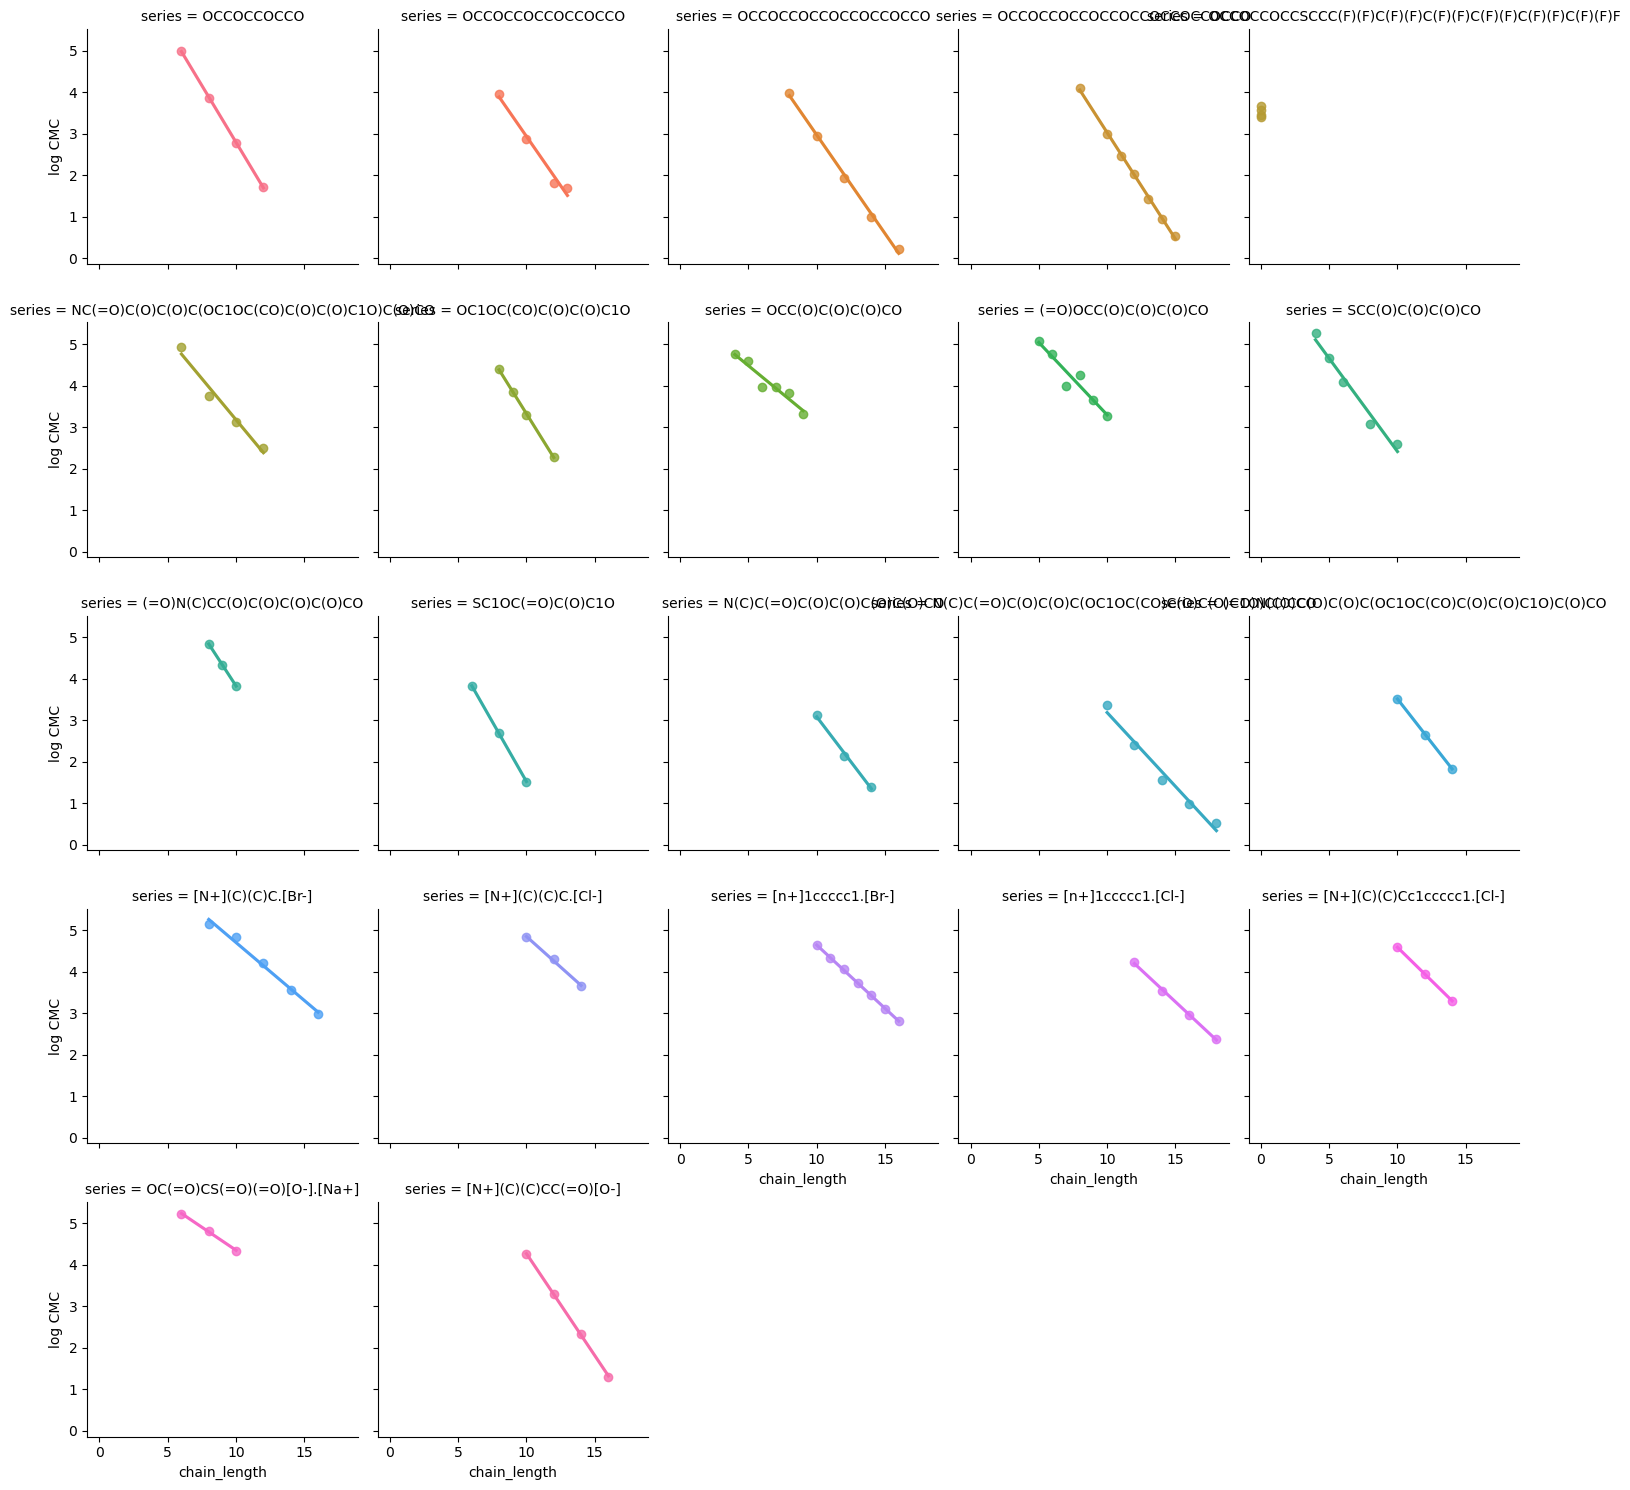

In [14]:
sns.lmplot(series_df, x="chain_length", y="log CMC", hue="series", col="series", col_wrap=5, ci=None, legend=False, height=3)

# What's happening with Series 9?

The above code only treats chains of CH2 groups as part of the tail. If the tail group has a different repeating unit, it fails...

In [15]:
series_df[series_df["chain_length"] == 0]

,smiles,log CMC,series,chain_length
30,OCCOCCOCCSCCC(F)(F)C(F)(F)C(F)(F)C(F)(F)C(F)(F...,3.397940,OCCOCCOCCSCCC(F)(F)C(F)(F)C(F)(F)C(F)(F)C(F)(F...,0.0
31,OCCOCCOCCOCCSCCC(F)(F)C(F)(F)C(F)(F)C(F)(F)C(F...,3.447158,OCCOCCOCCSCCC(F)(F)C(F)(F)C(F)(F)C(F)(F)C(F)(F...,0.0
32,OCCOCCOCCOCCOCCOCCSCCC(F)(F)C(F)(F)C(F)(F)C(F)...,3.568202,OCCOCCOCCSCCC(F)(F)C(F)(F)C(F)(F)C(F)(F)C(F)(F...,0.0
33,OCCOCCOCCOCCOCCOCCOCCOCCSCCC(F)(F)C(F)(F)C(F)(...,3.681241,OCCOCCOCCSCCC(F)(F)C(F)(F)C(F)(F)C(F)(F)C(F)(F...,0.0
